In [ ]:
# !pip install scrapbook
# !pip install lightfm
# !pip install recommenders

In [ ]:
import sys
import os

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scrapbook as sb

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k, map_at_k, ndcg_at_k

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
LightFM version: 1.16


In [ ]:
# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.25
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 42

In [ ]:
path = '/content/drive/MyDrive/쿠아이/쿠아이 컨퍼런스/2022 하계/'

In [ ]:
interaction = pd.read_csv(path + 'Grocery_and_Gourmet_Food_over_30_5_interaction.csv')
meta = pd.read_csv(path + 'FINAL_META_DATA.csv')
final_df = pd.read_csv(path + 'grocery_final.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data = final_df[['reviewerID','asin','overall','description_embedding','category2','category_embedding']]

In [ ]:
data.rename({'reviewerID':'userID', 'asin':'itemID', 'overall':'rating'}, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dataset = Dataset()

In [ ]:
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 2730, num_topics: 6186.


In [ ]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

In [ ]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED))

In [ ]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (2730, 6186)
Shape of test interactions: (2730, 6186)


# model1

In [ ]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEED))

In [ ]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

In [ ]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

In [ ]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

In [ ]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 3.4 seconds for prepare and predict test data.


In [ ]:
test_df.sample(5, random_state=SEED)

,userID,itemID,rating
8645,A3E5V5TSTAY3R9,B00FPNVTUW,5.0
12353,A1XAPRM0OO15SO,B00I5FWZA0,5.0
3261,A3HPZ6BIMNXSZR,B0013JC18G,2.0
11187,A1ASEZSAJBL10W,B002VLZ81M,5.0
16251,A19123D9G66E0O,B000QV8KNW,10.0


In [ ]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 13002.8 seconds for prepare and predict all data.


In [ ]:
all_predictions.sample(5, random_state=SEED)

,userID,itemID,prediction
6889778,A1I0YSG9M7BCCG,B00AKVU5H2,-22.616783
10241506,A1LVKURA7X0WJ2,B005P0WL1G,-254.189621
13489393,A7FIJG9N9TT0U,B01E60QYAY,-350.486694
14086989,A32L9QMSFGYO7T,B0050CL660,-110.872887
11282946,A2VBZ2YOWDFB7T,B002865CGG,-128.261292


In [ ]:
eval_map = map_at_k(test_df, all_predictions, k=K)
eval_ndcg = ndcg_at_k(test_df, all_predictions, k=K)
eval_precision = precision_at_k(test_df, all_predictions, k=K)
eval_recall = recall_at_k(test_df, all_predictions, k=K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.000179
NDCG:	0.000793
Precision@K:	0.000772
Recall@K:	0.000858


# model2

In [ ]:
final_df1 = final_df.copy()

In [ ]:
final_df1['category2'] = final_df1['category2'].apply(lambda x : x.replace('[','') )
final_df1['category2'] = final_df1['category2'].apply(lambda x : x.replace(']','') )

In [ ]:
category = [x.split(',') for x in final_df1['category2']]

In [ ]:
# retrieve the all the unique genres in the data
all_category = sorted(list(set(itertools.chain.from_iterable(category))))
# quick look at the all the genres within the data
all_category

[" 'Almonds'",
 " 'Asian'",
 " 'Baking Mixes'",
 " 'Bars'",
 " 'Beverages'",
 " 'Black'",
 " 'Bottled Beverages",
 " 'Breads & Bakery'",
 " 'Breakfast & Cereal Bars'",
 " 'Breakfast Foods'",
 " 'Cakes'",
 " 'Candy & Chocolate Assortments'",
 " 'Candy & Chocolate'",
 " 'Canned",
 " 'Cereals'",
 " 'Cheese'",
 " 'Chewing & Bubble Gum'",
 " 'Chips & Crisps'",
 " 'Chocolate & Fudge'",
 " 'Cocoa'",
 " 'Coconut'",
 " 'Coffee",
 " 'Coffee'",
 " 'Condiments & Salad Dressings'",
 " 'Cookies'",
 " 'Cooking & Baking'",
 " 'Cooking Oils",
 " 'Dried Beans",
 " 'Dried Fruits & Vegetables'",
 " 'Dried Fruits'",
 " 'Energy & Nutritional'",
 " 'Energy Drinks'",
 " 'Flours & Meals'",
 " 'Fresh Fruits'",
 " 'Fresh Vegetables'",
 " 'Frozen'",
 " 'Grains & Rice'",
 " 'Granola'",
 " 'Grocery & Gourmet Food'",
 " 'Ground Coffee'",
 " 'Gummy Candy'",
 " 'Hard Candy & Lollipops'",
 " 'Hard Candy'",
 " 'Herbal'",
 " 'Instant Coffee'",
 " 'Jams",
 " 'Jelly Beans & Gummy Candy'",
 " 'Jerky & Dried Meats'",
 " 'Jui

In [ ]:
data = final_df1[['reviewerID','asin','overall','category2']]

In [ ]:
data.rename({'reviewerID':'userID', 'asin':'itemID', 'overall':'rating', 'category2':'category'}, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
data

,userID,itemID,rating,category
0,APC57NVOKOO8J,B00BUKL666,4.0,"'Grocery & Gourmet Food', 'etc', 'Bars', 'Snac..."
1,A1J2G68M0POA10,B00BUKL666,5.0,"'Grocery & Gourmet Food', 'etc', 'Bars', 'Snac..."
2,AVO94A66EQGFH,B00BUKL666,5.0,"'Grocery & Gourmet Food', 'etc', 'Bars', 'Snac..."
3,A3V0NOZORAMPUW,B00BUKL666,4.0,"'Grocery & Gourmet Food', 'etc', 'Bars', 'Snac..."
4,A35BVXK8OTLZCH,B00BUKL666,5.0,"'Grocery & Gourmet Food', 'etc', 'Bars', 'Snac..."
...,...,...,...,...
86206,A7FIJG9N9TT0U,B01BTNSJ9A,5.0,"'etc', 'Grocery & Gourmet Food', 'Dried Fruits..."
86207,A308CDVRM1U6M0,B01BTNSJ9A,5.0,"'etc', 'Grocery & Gourmet Food', 'Dried Fruits..."
86208,A2V5R832QCSOMX,B01BTNSJ9A,5.0,"'etc', 'Grocery & Gourmet Food', 'Dried Fruits..."
86209,A2ZSEE1FMQUABO,B01BTNSJ9A,5.0,"'etc', 'Grocery & Gourmet Food', 'Dried Fruits..."


In [ ]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_category)

In [ ]:
item_features = dataset2.build_item_features((x, y) for x,y in zip(data.itemID, category))

In [ ]:
interactions2, weights2 = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, 
    test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED)
)

In [ ]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

In [ ]:
model2.fit(interactions=train_interactions2,
           item_features=item_features,
           epochs=NO_EPOCHS
           )

In [ ]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, 
    interactions2.col, 
    interactions2.data, 
    random_state=np.random.RandomState(SEED)
)

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

In [ ]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.") 

Took 3.4 seconds for prepare and predict test data.


In [ ]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 11963.7 seconds for prepare and predict all data.


In [ ]:
eval_map2 = map_at_k(test_df2, all_predictions2, k=K)
eval_ndcg2 = ndcg_at_k(test_df2, all_predictions2, k=K)
eval_precision2 = precision_at_k(test_df2, all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print("MAP:\t%f" % eval_map2,
      "NDCG:\t%f" % eval_ndcg2,
      "Precision@K:\t%f" % eval_precision2,
      "Recall@K:\t%f" % eval_recall2, sep='\n')

MAP:	0.005266
NDCG:	0.015583
Precision@K:	0.013203
Recall@K:	0.017592


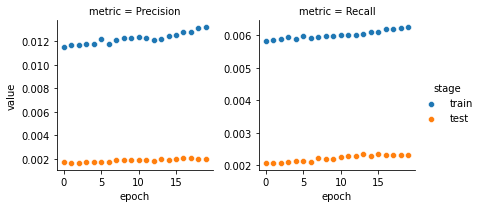

In [ ]:
output1, _ = track_model_metrics(model=model1, 
                                 train_interactions=train_interactions, 
                                 test_interactions=test_interactions, 
                                 k=K,
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS)

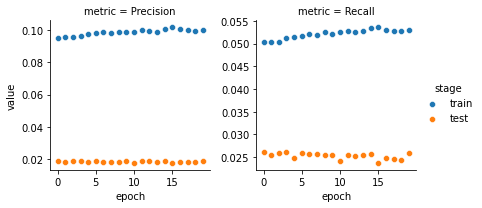

In [ ]:
output2, _ = track_model_metrics(model=model2, 
                                 train_interactions=train_interactions2, 
                                 test_interactions=test_interactions2, 
                                 k=K,                              
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS, 
                                 item_features=item_features,
                                 )

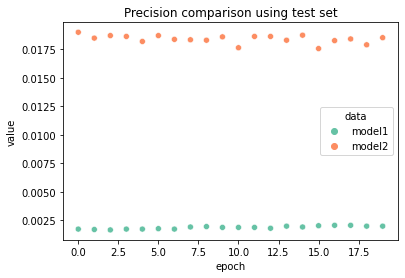

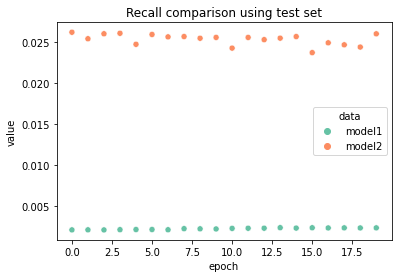

In [ ]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", 
                    y="value", 
                    hue='data',
                    data=compare_metric(df_list = [output1, output2], metric=i)
                   ).set_title(f'{i} comparison using test set');